In [2]:
%pip install transformers pillow

In [6]:
%pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 25.6 MB/s eta 0:00:0000:0100:01m


In [30]:
import cv2
from torchvision.transforms import v2
from PIL import Image
from typing import List, Union
from collections import Counter
import torch
import numpy as np
import random
from transformers import (
    RobertaTokenizerFast,
    VisionEncoderDecoderModel,
    GenerationConfig,
)
from matplotlib import pyplot as plt

In [8]:
tokenizer = RobertaTokenizerFast.from_pretrained("OleehyO/TexTeller")
model = VisionEncoderDecoderModel.from_pretrained("OleehyO/TexTeller")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
IMAGE_MEAN = 0.9545467
IMAGE_STD  = 0.15394445
FIXED_IMG_SIZE = 448

In [14]:
general_transform_pipeline = v2.Compose([
    v2.ToImage(),    
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.Grayscale(),

    v2.Resize(
        size=FIXED_IMG_SIZE - 1,
        interpolation=v2.InterpolationMode.BICUBIC,
        max_size=FIXED_IMG_SIZE,
        antialias=True
    ),

    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[IMAGE_MEAN], std=[IMAGE_STD]),

    # v2.ToPILImage()
])

In [15]:
def trim_white_border(image: np.ndarray):
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Image is not in RGB format or channel is not in third dimension")

    if image.dtype != np.uint8:
        raise ValueError(f"Image should stored in uint8")

    corners = [tuple(image[0, 0]), tuple(image[0, -1]),
               tuple(image[-1, 0]), tuple(image[-1, -1])]
    bg_color = Counter(corners).most_common(1)[0][0]
    bg_color_np = np.array(bg_color, dtype=np.uint8)
    
    h, w = image.shape[:2]
    bg = np.full((h, w, 3), bg_color_np, dtype=np.uint8)

    diff = cv2.absdiff(image, bg)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    threshold = 15
    _, diff = cv2.threshold(mask, threshold, 255, cv2.THRESH_BINARY)

    x, y, w, h = cv2.boundingRect(diff) 

    trimmed_image = image[y:y+h, x:x+w]

    return trimmed_image

def padding(images: List[torch.Tensor], required_size: int) -> List[torch.Tensor]:
    images = [  
        v2.functional.pad(
            img,
            padding=[0, 0, required_size - img.shape[2], required_size - img.shape[1]]
        )
        for img in images
    ]
    return images

In [16]:
def inference_transform(images: List[Union[np.ndarray, Image.Image]]) -> List[torch.Tensor]:
    assert IMG_CHANNELS == 1 , "Only support grayscale images for now"
    images = [np.array(img.convert('RGB')) if isinstance(img, Image.Image) else img for img in images]
    images = [trim_white_border(image) for image in images]
    # general transform pipeline
    images = [general_transform_pipeline(image) for image in  images]  # imgs: List[PIL.Image.Image]
    # padding to fixed size
    images = padding(images, FIXED_IMG_SIZE)

    return images

In [25]:
def inference(
    model, 
    tokenizer,
    imgs: Union[List[str], List[np.ndarray]], 
    accelerator: str = 'cpu',
    num_beams: int = 1,
    max_tokens = None
) -> List[str]:
    if imgs == []:
        return []
    model.eval()
    if isinstance(imgs[0], str):
        imgs = convert2rgb(imgs) 
    else:  # already numpy array(rgb format)
        assert isinstance(imgs[0], np.ndarray)
        imgs = imgs 
    imgs = inference_transform(imgs)
    pixel_values = torch.stack(imgs)

    # model = model.to(accelerator)
    # pixel_values = pixel_values.to(accelerator)

    generate_config = GenerationConfig(
        max_new_tokens=MAX_TOKEN_SIZE if max_tokens is None else max_tokens,
        num_beams=num_beams,
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
    )
    pred = model.generate(pixel_values, generation_config=generate_config)
    res = tokenizer.batch_decode(pred, skip_special_tokens=True)
    return res

In [36]:
import re


def change(input_str, old_inst, new_inst, old_surr_l, old_surr_r, new_surr_l, new_surr_r):
    result = ""
    i = 0
    n = len(input_str)
    
    while i < n:
        if input_str[i:i+len(old_inst)] == old_inst:
            # check if the old_inst is followed by old_surr_l
            start = i + len(old_inst)
        else:
            result += input_str[i]
            i += 1
            continue

        if start < n and input_str[start] == old_surr_l:
            # found an old_inst followed by old_surr_l, now look for the matching old_surr_r
            count = 1
            j = start + 1
            escaped = False
            while j < n and count > 0:
                if input_str[j] == '\\' and not escaped:
                    escaped = True
                    j += 1
                    continue
                if input_str[j] == old_surr_r and not escaped:
                    count -= 1
                    if count == 0:
                        break
                elif input_str[j] == old_surr_l and not escaped:
                    count += 1
                escaped = False
                j += 1
            
            if count == 0:
                assert j < n
                assert input_str[start] == old_surr_l
                assert input_str[j] == old_surr_r
                inner_content = input_str[start + 1:j]
                # Replace the content with new pattern
                result += new_inst + new_surr_l + inner_content + new_surr_r
                i = j + 1
                continue
            else:
                assert count >= 1
                assert j == n
                print("Warning: unbalanced surrogate pair in input string")
                result += new_inst + new_surr_l
                i = start + 1
                continue
        else:
            result += input_str[i:start]
            i = start
    
    if old_inst != new_inst and (old_inst + old_surr_l) in result:
        return change(result, old_inst, new_inst, old_surr_l, old_surr_r, new_surr_l, new_surr_r)
    else:
        return result


def find_substring_positions(string, substring):
    positions = [match.start() for match in re.finditer(re.escape(substring), string)]
    return positions


def rm_dollar_surr(content):
    pattern = re.compile(r'\\[a-zA-Z]+\$.*?\$|\$.*?\$')
    matches = pattern.findall(content)
    
    for match in matches:
        if not re.match(r'\\[a-zA-Z]+', match):
            new_match = match.strip('$')
            content = content.replace(match, ' ' + new_match + ' ')
    
    return content


def change_all(input_str, old_inst, new_inst, old_surr_l, old_surr_r, new_surr_l, new_surr_r):
    pos = find_substring_positions(input_str, old_inst + old_surr_l)
    res = list(input_str)
    for p in pos[::-1]:
        res[p:] = list(change(''.join(res[p:]), old_inst, new_inst, old_surr_l, old_surr_r, new_surr_l, new_surr_r))
    res = ''.join(res)
    return res


def to_katex(formula: str) -> str:
    res = formula
    # remove mbox surrounding
    res = change_all(res, r'\mbox ', r' ', r'{', r'}', r'', r'')
    res = change_all(res, r'\mbox', r' ', r'{', r'}', r'', r'')
    # remove hbox surrounding
    res = re.sub(r'\\hbox to ?-? ?\d+\.\d+(pt)?\{', r'\\hbox{', res)
    res = change_all(res, r'\hbox', r' ', r'{', r'}', r'', r' ')
    # remove raise surrounding
    res = re.sub(r'\\raise ?-? ?\d+\.\d+(pt)?', r' ', res)
    # remove makebox
    res = re.sub(r'\\makebox ?\[\d+\.\d+(pt)?\]\{', r'\\makebox{', res)
    res = change_all(res, r'\makebox', r' ', r'{', r'}', r'', r' ')
    # remove vbox surrounding, scalebox surrounding
    res = re.sub(r'\\raisebox\{-? ?\d+\.\d+(pt)?\}\{', r'\\raisebox{', res)
    res = re.sub(r'\\scalebox\{-? ?\d+\.\d+(pt)?\}\{', r'\\scalebox{', res)
    res = change_all(res, r'\scalebox', r' ', r'{', r'}', r'', r' ')
    res = change_all(res, r'\raisebox', r' ', r'{', r'}', r'', r' ')
    res = change_all(res, r'\vbox', r' ', r'{', r'}', r'', r' ')


    origin_instructions = [
        r'\Huge',
        r'\huge',
        r'\LARGE',
        r'\Large',
        r'\large',
        r'\normalsize',
        r'\small',
        r'\footnotesize',
        r'\tiny'
    ]
    for (old_ins, new_ins) in zip(origin_instructions, origin_instructions):
        res = change_all(res, old_ins, new_ins, r'$', r'$', '{', '}')
    res = change_all(res, r'\boldmath ', r'\bm', r'{', r'}', r'{', r'}')
    res = change_all(res, r'\boldmath', r'\bm', r'{', r'}', r'{', r'}')
    res = change_all(res, r'\boldmath ', r'\bm', r'$', r'$', r'{', r'}')
    res = change_all(res, r'\boldmath', r'\bm', r'$', r'$', r'{', r'}')
    res = change_all(res, r'\scriptsize', r'\scriptsize', r'$', r'$', r'{', r'}')
    res = change_all(res, r'\emph', r'\textit', r'{', r'}', r'{', r'}')
    res = change_all(res, r'\emph ', r'\textit', r'{', r'}', r'{', r'}')
    
    origin_instructions = [
        r'\left',
        r'\middle',
        r'\right',
        r'\big',
        r'\Big',
        r'\bigg',
        r'\Bigg',
        r'\bigl',
        r'\Bigl',
        r'\biggl',
        r'\Biggl',
        r'\bigm',
        r'\Bigm',
        r'\biggm',
        r'\Biggm',
        r'\bigr',
        r'\Bigr',
        r'\biggr',
        r'\Biggr'
    ]
    for origin_ins in origin_instructions:
        res = change_all(res, origin_ins, origin_ins, r'{', r'}', r'', r'')

    res = re.sub(r'\\\[(.*?)\\\]', r'\1\\newline', res)

    if res.endswith(r'\newline'):
        res = res[:-8]

    # remove multiple spaces
    res = re.sub(r'(\\,){1,}', ' ', res)
    res = re.sub(r'(\\!){1,}', ' ', res)
    res = re.sub(r'(\\;){1,}', ' ', res)
    res = re.sub(r'(\\:){1,}', ' ', res)
    res = re.sub(r'\\vspace\{.*?}', '', res)

    # merge consecutive text
    def merge_texts(match):
        texts = match.group(0)
        merged_content = ''.join(re.findall(r'\\text\{([^}]*)\}', texts))
        return f'\\text{{{merged_content}}}'
    res = re.sub(r'(\\text\{[^}]*\}\s*){2,}', merge_texts, res)

    res = res.replace(r'\bf ', '')
    res = rm_dollar_surr(res)

    # remove extra spaces (keeping only one)
    res = re.sub(r' +', ' ', res)

    return res.strip()

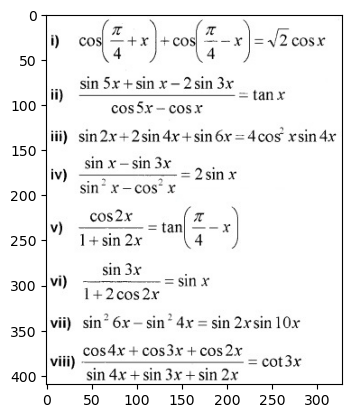

In [37]:
img_path = "Plus-One-Maths-Chapter-Wise-Questions-and-Answers-Chapter-3-Trigonometric-Functions-3M-Q1.jpg"
img = cv2.imread(img_path)
plt.imshow(img)

In [38]:
res = inference(model, tokenizer, [img])
res

['\\[\\begin{split}&\\text{\\sf{ij}}\\quad\\cos\\!\\!\\left(\\frac{\\pi}{4}+x \\right)\\!+\\cos\\!\\!\\left(\\frac{\\pi}{4}-x\\right)\\!\\!=\\!\\sqrt{2}\\,\\cos x\\\\ &\\text{\\sf{iii)}}\\quad\\frac{\\sin\\,5x+\\sin\\,x-2\\sin\\,3x}{\\cos 5x- \\cos x}\\!=\\tan x\\\\ &\\text{\\sf{iii)}}\\ \\ \\sin 2x+2\\sin\\,4x+\\!\\sin 6x\\!=\\!4\\cos^{ \\!2}x\\sin 4x\\\\ &\\text{\\sf{iv)}}\\ \\ \\frac{\\sin\\,x-\\sin\\,3x}{\\sin^{\\,{}^{2}}x-\\cos^{ \\!{}^{2}}x}=2\\sin\\,x\\\\ &\\text{\\sf{iv)}}\\ \\ \\frac{\\cos 2x}{1+\\sin\\,2x}=\\tan\\!\\!\\left(\\frac{\\pi}{4}-x \\right)\\\\ &\\text{\\sf{vii)}}\\ \\ \\frac{\\sin\\,3x}{1+2\\cos 2x}=\\sin\\,x\\\\ &\\text{\\sf{viii)}}\\ \\ \\sin^{\\,{}^{2}}6x-\\sin^{\\,{}^{2}}4x=\\sin\\,2x\\sin 10x \\\\ &\\text{\\sf{viii)}}\\ \\ \\frac{\\cos 4x+\\cos 3x+\\cos 2x}{\\sin 4x+\\sin 3x+\\sin 2x}= \\cot 3x\\end{split}\\]']

In [39]:
res = to_katex(res[0])
print(res)

\begin{split}&\text{\sf{ij}}\quad\cos \left(\frac{\pi}{4}+x \right) +\cos \left(\frac{\pi}{4}-x\right) = \sqrt{2} \cos x\\ &\text{\sf{iii)}}\quad\frac{\sin 5x+\sin x-2\sin 3x}{\cos 5x- \cos x} =\tan x\\ &\text{\sf{iii)}}\ \ \sin 2x+2\sin 4x+ \sin 6x = 4\cos^{ 2}x\sin 4x\\ &\text{\sf{iv)}}\ \ \frac{\sin x-\sin 3x}{\sin^{ {}^{2}}x-\cos^{ {}^{2}}x}=2\sin x\\ &\text{\sf{iv)}}\ \ \frac{\cos 2x}{1+\sin 2x}=\tan \left(\frac{\pi}{4}-x \right)\\ &\text{\sf{vii)}}\ \ \frac{\sin 3x}{1+2\cos 2x}=\sin x\\ &\text{\sf{viii)}}\ \ \sin^{ {}^{2}}6x-\sin^{ {}^{2}}4x=\sin 2x\sin 10x \\ &\text{\sf{viii)}}\ \ \frac{\cos 4x+\cos 3x+\cos 2x}{\sin 4x+\sin 3x+\sin 2x}= \cot 3x\end{split}
